In [1]:
import re
import shutil

import cv2
import imagesize
from src.std_imports import os, pd, np
from skmultilearn.model_selection import iterative_train_test_split

from src import annotations_processing as ap
from src import image_processing as ip
from src import constants as c
from train import multi_hot_labels



pascal_df: pd.DataFrame = ap.xml_annotations_to_dataframe(r'kaggle\input\codebrim-original\original_dataset\annotations')

original_img_dir = r'kaggle\input\codebrim-original\original_dataset\images'

(5261, 4)
(5261, 6)
(5261, 4)
(5261, 6)


In [2]:
import pandas as pd
import os




def fill_missing_imgs_in_df(img_folder, input_df):
    # Get list of images
    img_list = []
    for dirpath, dirnames, filenames in os.walk(img_folder):
        if dirpath == img_folder:
            img_list = filenames
            break

    # Process images sequentially
    results = []
    for img in img_list:
        if img not in input_df['img'].tolist():
            img_path = os.path.join(os.getcwd(), img_folder, img)
            # using awesome imagesize lib! Super fast! super cool!
            # https://github.com/shibukawa/imagesize_py
            shape = imagesize.get(img_path)
            l = [0] * len(c.pascal_cols_list)
            l[0] = img
            l[1] = shape[0]
            l[2] = shape[1]
            l[7] = 1
            results.append(l)

    # Filter out None results and add to DataFrame
    out_df = 0
    if results:
        out_df = pd.concat([input_df, pd.DataFrame(results, columns=c.pascal_cols_list)], ignore_index=True)
    return out_df

# Usage
pascal_df = fill_missing_imgs_in_df(original_img_dir, pascal_df)

In [3]:
pascal_df.sort_values(by=['img'], ascending=True, inplace=True)
pascal_df[pascal_df['Background'] == 1]

,img,img_width,img_height,xmin,ymin,xmax,ymax,Background,Crack,Spallation,Efflorescence,ExposedBars,CorrosionStain
5261,image_0000001.jpg,1712,2572,0,0,0,0,1,0,0,0,0,0
5262,image_0000002.jpg,1732,2596,0,0,0,0,1,0,0,0,0,0
5263,image_0000003.jpg,1732,2596,0,0,0,0,1,0,0,0,0,0
5264,image_0000004.jpg,1688,2532,0,0,0,0,1,0,0,0,0,0
5265,image_0000006.jpg,1972,2960,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,image_0001586.jpg,4608,3456,0,0,0,0,1,0,0,0,0,0
5798,image_0001587.jpg,4608,3456,0,0,0,0,1,0,0,0,0,0
5226,image_0001594.jpg,4608,3456,2000,16,3347,2863,1,0,0,0,0,0
5229,image_0001594.jpg,4608,3456,3802,1500,4608,2742,1,0,0,0,0,0


In [4]:
yolo_df = ap.pascal_df_to_yolo(pascal_df)
yolo_df

,img,img_width,img_height,Background,Crack,Spallation,Efflorescence,ExposedBars,CorrosionStain,multihot_encoding_class,x_center,y_center,bbox_width,bbox_height
5261,image_0000001.jpg,1712,2572,1,0,0,0,0,0,32,0.000000,0.000000,0.000000,0.000000
5262,image_0000002.jpg,1732,2596,1,0,0,0,0,0,32,0.000000,0.000000,0.000000,0.000000
5263,image_0000003.jpg,1732,2596,1,0,0,0,0,0,32,0.000000,0.000000,0.000000,0.000000
5264,image_0000004.jpg,1688,2532,1,0,0,0,0,0,32,0.000000,0.000000,0.000000,0.000000
0,image_0000005.jpg,1904,2856,0,0,0,1,0,1,5,0.289391,0.611607,0.115896,0.727416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,image_0001599.jpg,4608,3456,0,0,1,0,1,1,11,0.727141,0.086914,0.342593,0.173394
5258,image_0001599.jpg,4608,3456,0,0,0,0,0,1,1,0.126302,0.294162,0.121817,0.587891
5259,image_0001599.jpg,4608,3456,0,0,0,1,0,1,5,0.569010,0.494032,0.558160,0.511936
5253,image_0001599.jpg,4608,3456,0,0,0,0,0,1,1,1.023582,0.386285,0.114873,0.453993


In [5]:
if len(os.path.join(os.getcwd(), 'yolo_labels')) == 0:
    yolo_labels_dir = os.path.join(os.getcwd(), 'yolo_labels')
    ap.save_yolo_annotations(yolo_df, yolo_labels_dir)

In [6]:
def train_test_val_image_split(input_df: pd.DataFrame, test_size: float = 0.2,
                               val_size: float = 0.1) -> dict[str, np.ndarray]:
    """
    Splits the input DataFrame into training, testing, and validation sets
    based on images. If there are multiple entries of the same image_path, it merges them by
    maximum value of each label.

    Parameters:
    ----------
    input_df : pd.DataFrame
        A pandas DataFrame containing column 'img' with file names, bounding box coordinates
        in format (xmin, xmax, ymin, ymax) and their corresponding multi-hot encoded labels.
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split.
    val_size : float, default=0.1
        Proportion of the dataset to include in the validation split.

    Returns:
    -------
    dict[str, np.ndarray]
        A dictionary with keys 'train', 'test', and 'val',
        each containing a NumPy array of image_path file names for the respective dataset.
    """
    if input_df.empty:
        raise ValueError('Input DataFrame is empty')

    if not (0 < test_size < 1) or not (0 <= val_size < 1):
        raise ValueError("test_size and val_size must be between 0 and 1.")

    if (test_size + val_size) >= 1:
        raise ValueError("The sum of test_size and val_size must be less than 1.")

    # Create a dictionary to store max values for each image
    grouped_data = {}
    for img_name, group in input_df.groupby(c.IMG):
        grouped_data[img_name] = group[c.defect_names].max().to_numpy()

    # Create new DataFrame with unique images and their labels
    grouped_df = pd.DataFrame(columns=[c.IMG] + c.defect_names)
    grouped_df[c.IMG] = list(grouped_data.keys())
    mhot_labels = np.array(list(grouped_data.values()))

    for i, defect in enumerate(c.defect_names):
        grouped_df[defect] = mhot_labels[:, i]

    # Prepare data for split
    X = grouped_df[c.IMG].to_numpy().reshape(-1, 1)  # Make it 2D array
    y = grouped_df[c.defect_names].to_numpy()

    # Split the data
    X_train, y_train, X_temp, y_temp = iterative_train_test_split(
        X, y, test_size=(1 - test_size + val_size)
    )

    X_test, y_test, X_val, y_val = iterative_train_test_split(
        X_temp, y_temp, test_size=test_size / (test_size + val_size)
    )

    return {
        'train': X_train.flatten(),
        'test': X_test.flatten(),
        'val': X_val.flatten()
    }

In [7]:
train_test_val = train_test_val_image_split(yolo_df, test_size=0.2, val_size=0.1)
train_test_val

{'train': array(['image_0000001.jpg', 'image_0000003.jpg', 'image_0000006.jpg',
        'image_0000008.jpg', 'image_0000010.jpg', 'image_0000012.jpg',
        'image_0000014.jpg', 'image_0000016.jpg', 'image_0000018.jpg',
        'image_0000020.jpg', 'image_0000023.jpg', 'image_0000025.jpg',
        'image_0000027.jpg', 'image_0000028.jpg', 'image_0000030.jpg',
        'image_0000032.jpg', 'image_0000035.jpg', 'image_0000037.jpg',
        'image_0000039.jpg', 'image_0000041.jpg', 'image_0000044.jpg',
        'image_0000047.jpg', 'image_0000049.jpg', 'image_0000050.jpg',
        'image_0000052.jpg', 'image_0000053.jpg', 'image_0000056.jpg',
        'image_0000058.jpg', 'image_0000060.jpg', 'image_0000062.jpg',
        'image_0000064.jpg', 'image_0000066.jpg', 'image_0000068.jpg',
        'image_0000070.jpg', 'image_0000072.jpg', 'image_0000075.jpg',
        'image_0000077.jpg', 'image_0000078.jpg', 'image_0000080.jpg',
        'image_0000082.jpg', 'image_0000088.jpg', 'image_0000090.jpg

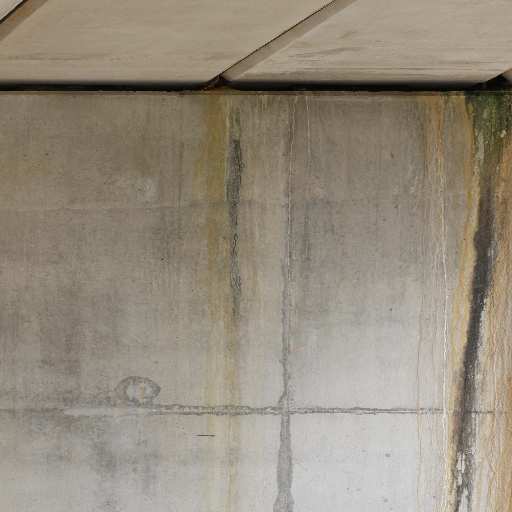

In [8]:
ip.resize_image_gpu(r'D:\0-Code\PG\2_sem\0_Dyplom\ai-capstone-proj\examples\image_0000005.jpg', 512, 512)

In [11]:
import os

# Use raw strings or forward slashes to avoid escape sequence warnings
i1 = os.path.join(os.getcwd(), r'kaggle/input/codebrim-original/original_dataset/images')
i2 = os.path.join(os.getcwd(), r'images\images_resized')

if not os.path.exists(i2):
    #print(os.listdir(i2))
    os.makedirs(i2)

if len(os.listdir(i2)) == 0:
    ip.resize_images_pytorch(input_dir=i1, output_dir=i2,
                            target_width=640, target_height=640, delete_output_dir=True)

100%|██████████| 1590/1590 [08:23<00:00,  3.16it/s]

Resizing done.


In [10]:
def put_imgs_in_folders(input_dict: dict[str, np.ndarray], input_dir: str, base_out_dir: str) -> None:
    list_of_out_dirs = []
    for k in input_dict.keys():
        out_dir = os.path.join(base_out_dir, k)
        list_of_out_dirs.append(out_dir)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        elif len(os.listdir(out_dir)) != 0:
            raise ValueError('Output directory {} already exists'.format(out_dir))

        for img_name in input_dict[k]:
            input_img_path = os.path.join(input_dir, img_name)
            out_img_path = os.path.join(out_dir, img_name)
            shutil.copy(input_img_path, out_img_path)

        print('Copying images to {} finished!'.format(out_dir))

put_imgs_in_folders(train_test_val, i2, i2)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\0-Code\\PG\\2_sem\\0_Dyplom\\ai-capstone-proj\\images\\images_resized\\image_0000058.jpg'